# Определение возраста покупателей

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
# Настройка отображения графиков

%matplotlib inline
sns.set(font_scale=1.3, 
        style="whitegrid", 
        rc={'figure.figsize': (20, 7)})
pd.set_option('display.max_colwidth', 
              None)

In [3]:
# Визуализация изображений

def plot_images_with_labels(features, labels, num_images=12):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(features))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(features[i])
        plt.title(f"Age: {int(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
# Загрузка данных

labels = pd.read_csv('/datasets/faces/labels.csv')

## Исследовательский анализ данных

In [5]:
display(labels.head())
display(labels.describe())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
print("Размеры датасета:", labels.shape)

Размеры датасета: (7591, 2)


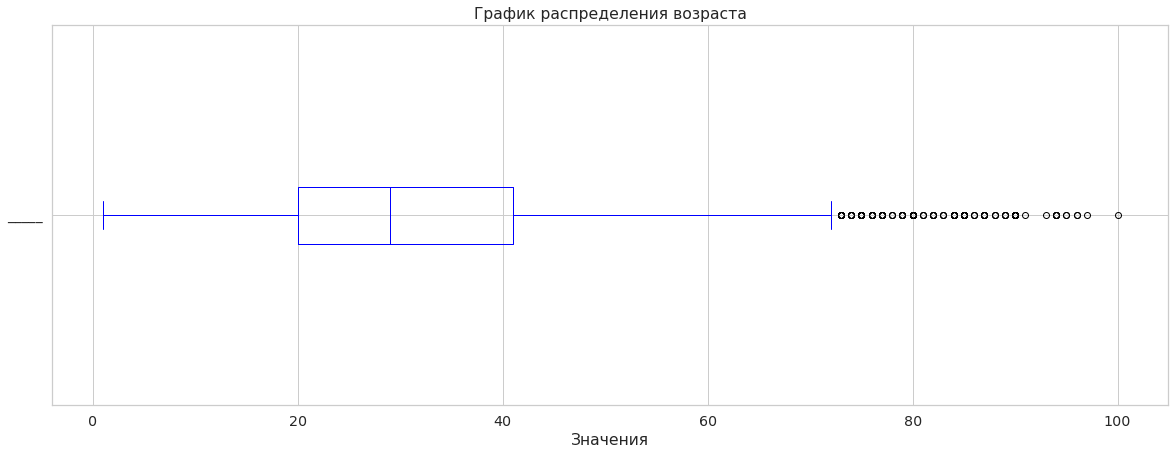

In [7]:
# График Boxplot

labels.boxplot(['real_age'], vert=False, color='blue')
plt.title('График распределения возраста')
plt.xlabel('Значения')
plt.yticks([1], ['_____'])
plt.show();

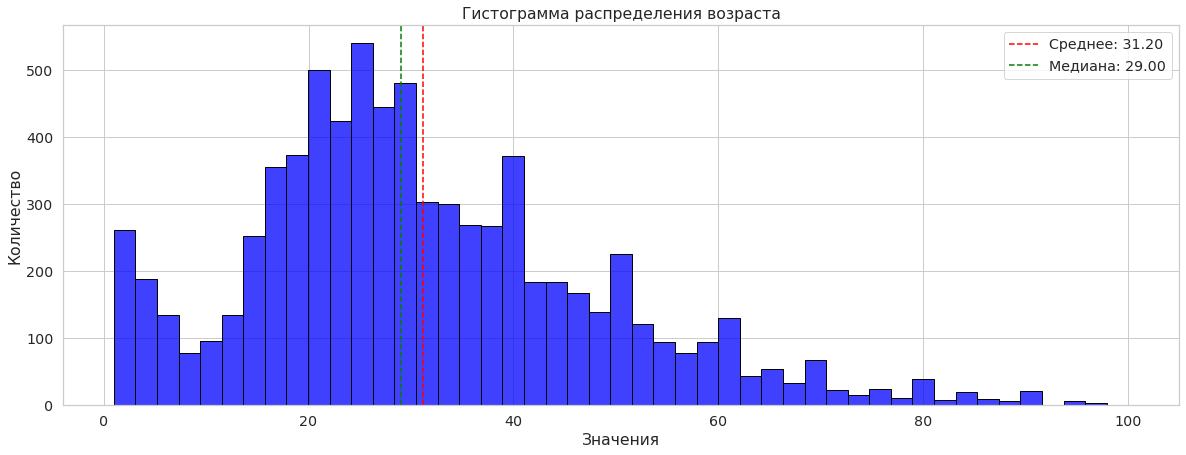

In [8]:
# Гистограмма

sns.histplot(labels['real_age'], 
             color='blue', 
             edgecolor='black')
plt.title("Гистограмма распределения возраста")
plt.axvline(labels['real_age'].mean(), 
            color='red', 
            linestyle='--', 
            label=f"Среднее: {labels['real_age'].mean():.2f}")
plt.axvline(labels['real_age'].median(), 
            color='green', 
            linestyle='--', 
            label=f"Медиана: {labels['real_age'].median():.2f}")
plt.xlabel("Значения")
plt.ylabel("Количество")
plt.legend()
plt.show()

In [9]:
# Подготовка данных для обучения

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


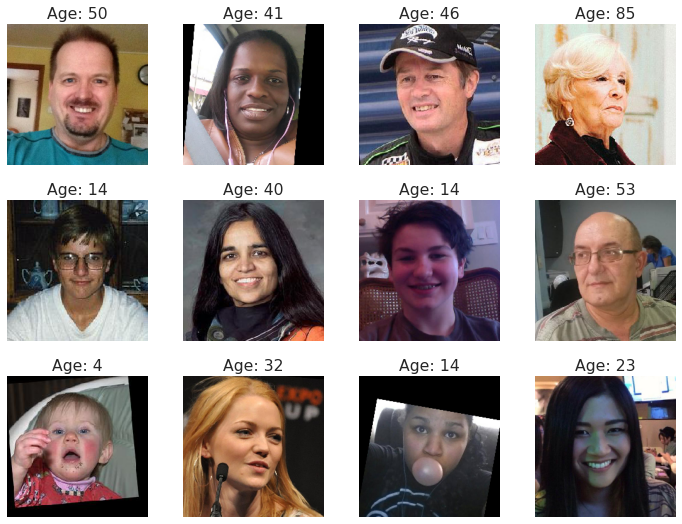

In [10]:
# Визуализация первых 10 изображений

features, target = next(train_gen_flow)
plot_images_with_labels(features, target)

**Вывод:**

- в датасете 7591 фото;
- есть фото с лишними объектами как жевачка, очки, головные уборы;
- много фото, сделанных под углом;
- самый популярный возраст в промежутке 20-30 лет;
- Средний возраст — около 31 года, что соответствует молодому и зрелому населению.
- Стандартное отклонение — 17 лет, что указывает на широкий разброс возрастов.
- Минимальный возраст — 1 год, максимальный — 100 лет. Это подтверждает наличие младенцев и пожилых людей.
- потенциальные проблемы связаны с дисбалансом данных: слабо представлен возраст 40+. Возможно, потребуется аугментация данных, но сначала стоит провести обучение без нее.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

356/356 - 82s - loss: 193.3705 - mae: 10.3912 - val_loss: 481.2490 - val_mae: 16.8622
Epoch 2/15
356/356 - 47s - loss: 98.2941 - mae: 7.5826 - val_loss: 299.8245 - val_mae: 12.9611
Epoch 3/15
356/356 - 46s - loss: 59.4706 - mae: 5.9333 - val_loss: 184.0306 - val_mae: 10.1844
Epoch 4/15
356/356 - 42s - loss: 40.7183 - mae: 4.9445 - val_loss: 101.2512 - val_mae: 7.4794
Epoch 5/15
356/356 - 42s - loss: 29.2497 - mae: 4.2084 - val_loss: 85.0461 - val_mae: 7.1372
Epoch 6/15
356/356 - 42s - loss: 20.9025 - mae: 3.5005 - val_loss: 123.6978 - val_mae: 8.8919
Epoch 7/15
356/356 - 42s - loss: 15.8268 - mae: 3.0421 - val_loss: 91.5179 - val_mae: 7.1981
Epoch 8/15
356/356 - 42s - loss: 13.6844 - mae: 2.8181 - val_loss: 70.0491 - val_mae: 6.3115
Epoch 9/15
356/356 - 42s - loss: 12.9838 - mae: 2.7380 - val_loss: 109.1339 - val_mae: 7.7175
Epoch 10/15
356/356 - 42s - loss: 13.0884 - mae: 2.7633 - val_loss: 76.6029 - val_mae: 6.5452
Epoch 11/15
356/356 - 42s - loss: 17.0738 - mae: 3.1453 - val_loss: 200.0515 - val_mae: 11.6267
Epoch 12/15
356/356 - 42s - loss: 19.1312 - mae: 3.3518 - val_loss: 89.0470 - val_mae: 7.2372
Epoch 13/15
356/356 - 42s - loss: 20.3834 - mae: 3.4460 - val_loss: 89.1999 - val_mae: 7.0243
Epoch 14/15
356/356 - 42s - loss: 14.6274 - mae: 2.9209 - val_loss: 114.3828 - val_mae: 7.9648
Epoch 15/15
356/356 - 42s - loss: 9.8725 - mae: 2.3960 - val_loss: 70.9585 - val_mae: 6.2937


```

## Анализ обученной модели

**Общая производительность:** 
Модель демонстрирует значительное снижение значения функции потерь (loss) и средней абсолютной ошибки (mae) на обучающем наборе данных и валидационном наборе данных на протяжении всех эпох. Это указывает на то, что модель обучается и улучшает свои предсказания.

**Тренировочные и валидационные метрики:**

На первой эпохе значение loss составляет 193.3705, а mae — 10.3912. К пятой эпохе loss снижается до 29.2497, а mae — до 4.2084. Это говорит о том, что модель значительно улучшила свои предсказания.

Валидационные метрики также показывают улучшение: val_loss снижается с 481.2490 до 85.0461 к пятой эпохе, а val_mae — с 16.8622 до 7.1372.

**Результаты:** 

На последней эпохе (15-й) модель достигает loss 9.8725 и mae 2.3960 на обучающем наборе, а val_loss составляет 70.9585, а val_mae — 6.2937. Эти значения показывают, что модель в целом хорошо обучена, но есть возможность улучшения, особенно в отношении валидационных метрик.
